## ARIMA Y SARIMAX

Lo primero será entender la **dependencia temporal** de tu serie antes de modelar:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 140)
np.set_printoptions(suppress=True)


In [2]:
df = pd.read_parquet('bermejales.gzip')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df.set_index('datetime')
print(df.head())

                            co      no2      o3  pm10     tmp      vv
datetime                                                             
2005-01-01 00:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2005-01-01 01:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2005-01-01 02:00:00  2024.6667  26.6667  7.5000   NaN  6.6667  1.0000
2005-01-01 03:00:00  2229.3333  19.6667  5.5000   NaN  6.1667  0.3333
2005-01-01 04:00:00  2096.1667  19.5000  4.6667   NaN  5.3333  0.8333


Mostrando datos desde 2023-10-08 hasta 2023-12-31


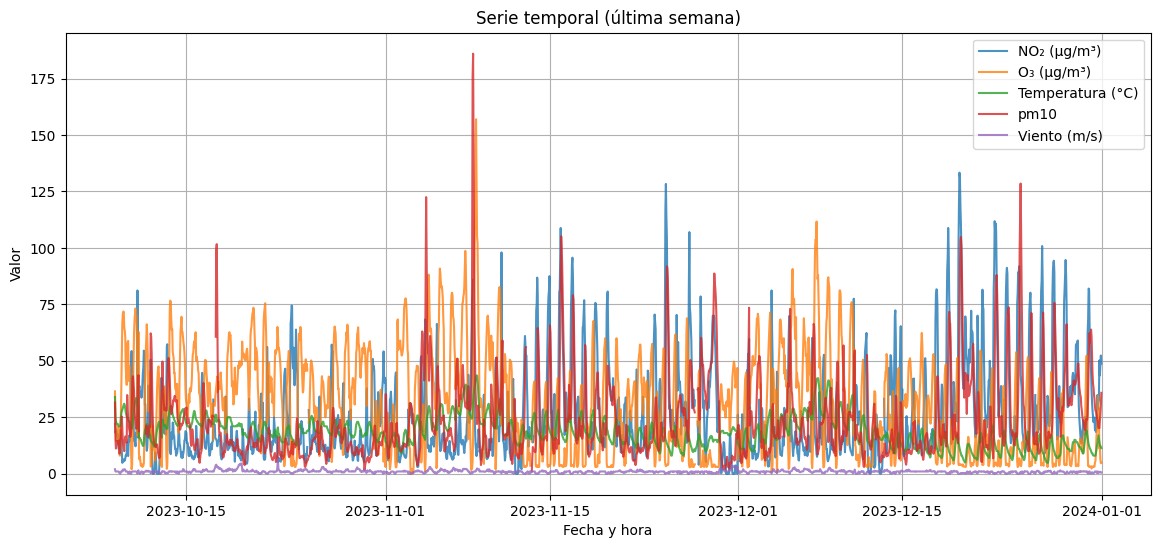

In [3]:
ultima_fecha = df.index.max()
inicio_meses = ultima_fecha - pd.Timedelta(weeks=12)
df_3meses = df.loc[inicio_meses:ultima_fecha]

print(f"Mostrando datos desde {inicio_meses.date()} hasta {ultima_fecha.date()}")

# --- 🔹 Graficar las variables principales ---
plt.figure(figsize=(14, 6))
plt.plot(df_3meses.index, df_3meses['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['pm10'], label='pm10', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
df_3meses = df_3meses.drop(columns=['co'])


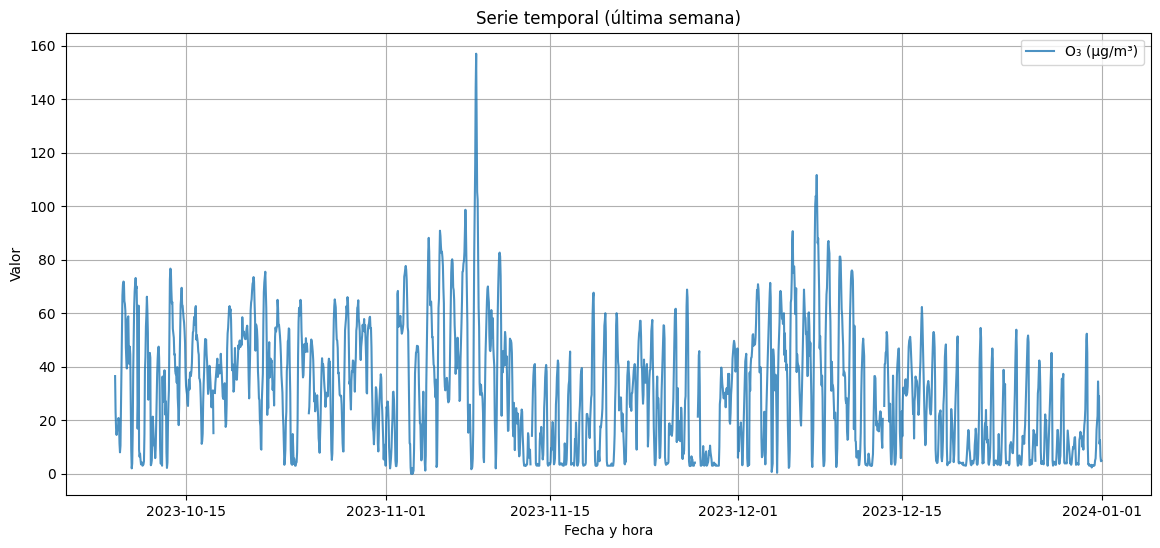

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df_3meses.index, df_3meses['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

##  `lag_plot`: relación simple entre consecutivos (lag=1)

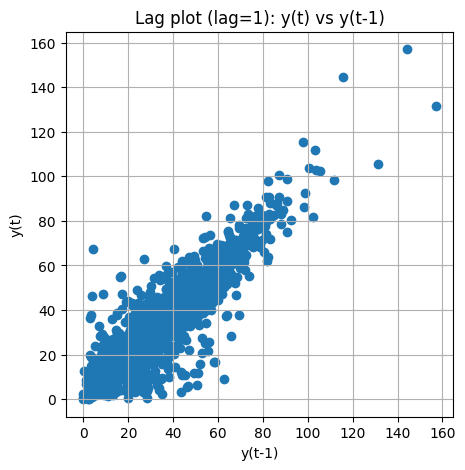

In [6]:

plt.figure(figsize=(5,5))
lag_plot(df_3meses['o3'])  # por defecto lag=1
plt.title("Lag plot (lag=1): y(t) vs y(t-1)")
plt.xlabel("y(t-1)"); plt.ylabel("y(t)"); plt.grid(True); plt.show()

Como los puntos se alinean en la diagonal -> hay autocorrelación positiva.  

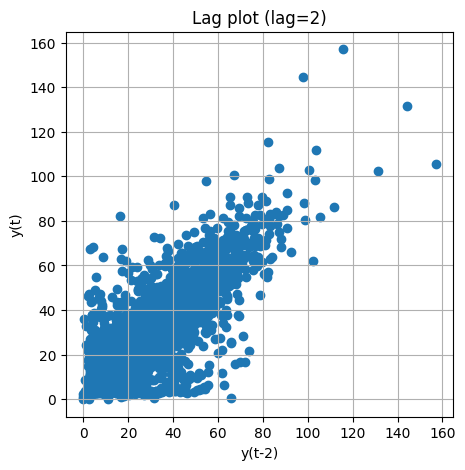

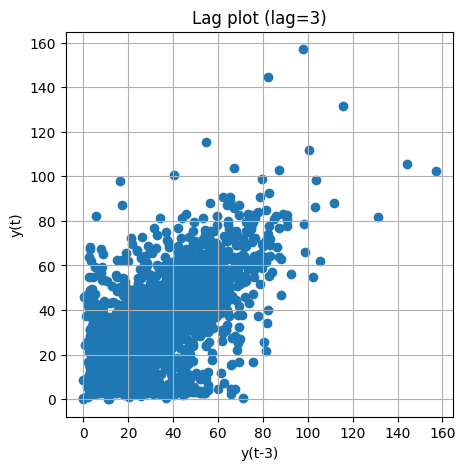

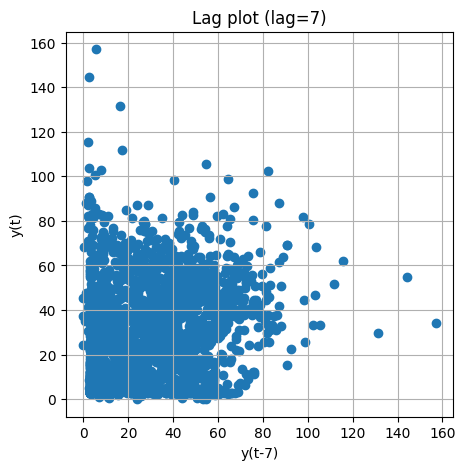

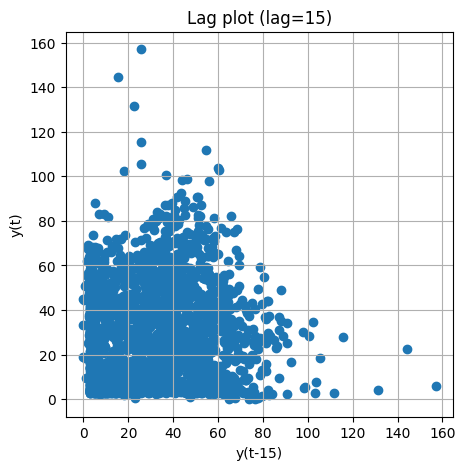

In [7]:

for lag in [2, 3, 7, 15]:
    plt.figure(figsize=(5,5))
    lag_plot(df_3meses['o3'], lag=lag)
    plt.title(f"Lag plot (lag={lag})")
    plt.xlabel(f"y(t-{lag})"); plt.ylabel("y(t)"); plt.grid(True); plt.show()

In [8]:
df_3meses

,no2,o3,pm10,tmp,vv
datetime,,,,,
2023-10-08 23:00:00,22.1667,36.5000,31.5000,34.0000,2.0000
2023-10-09 00:00:00,18.1667,23.0000,15.1667,24.8333,1.0000
2023-10-09 01:00:00,19.0000,16.8333,11.1667,23.3333,1.0000
2023-10-09 02:00:00,19.1667,14.5000,12.3333,22.3333,1.0000
2023-10-09 03:00:00,16.5000,16.5000,14.5000,22.0000,1.0000
...,...,...,...,...,...
2023-12-31 19:00:00,50.1667,11.1667,20.1667,14.5000,0.6667
2023-12-31 20:00:00,43.5000,12.5000,23.5000,12.8333,0.8333
2023-12-31 21:00:00,47.6667,6.5000,26.0000,12.0000,0.8333


In [9]:
df_interp = df_3meses.copy()
for col in df_interp.columns:
    # interpolación temporal; limit=6 -> no imputa tramos mayores a 6 horas (ajusta)
    df_interp[col] = df_interp[col].interpolate(method='time', limit=6)

In [10]:
y = df_interp['o3'].astype(float)

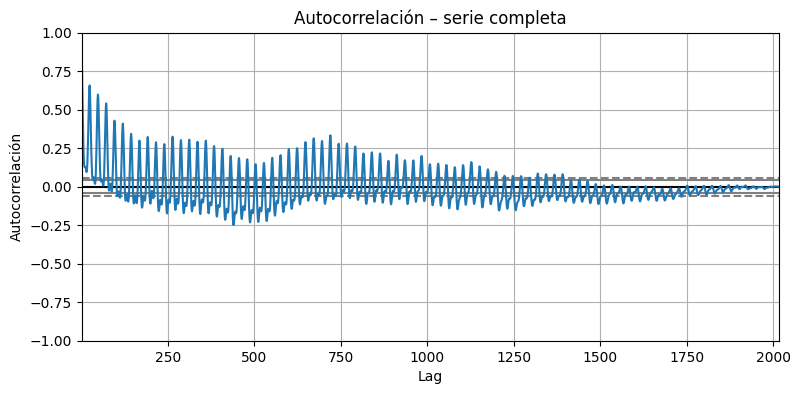

In [11]:
plt.figure(figsize=(9,4))
autocorrelation_plot(df_interp['o3'])
plt.title("Autocorrelación – serie completa")
plt.xlabel("Lag"); plt.ylabel("Autocorrelación"); plt.grid(True); plt.show()

# ARIMA(p,d,q): 

p ->  AutoRegresivo (AR) -> Cuántos valores pasados del target (y) se usan para predecir el actual

d  -> Diferenciación -> Cuántas veces se diferencia la serie para hacerla estacionaria

q -> Media movil -> Cuántos errores pasados del modelo se usan en la predicción

Función de autocorrelación parcial (PACF) -> para determinar la p

<Figure size 1000x500 with 0 Axes>

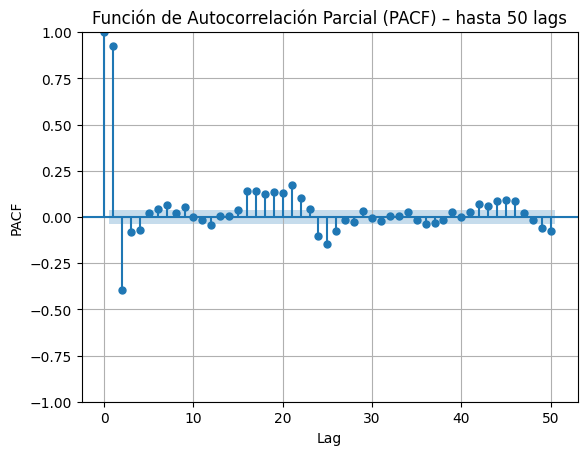

In [12]:
LAGS_PACF = 50  # ajusta según tu serie
plt.figure(figsize=(10,5))
plot_pacf(df_interp['o3'], lags=LAGS_PACF, alpha=0.1, method="ywm")
plt.title(f"Función de Autocorrelación Parcial (PACF) – hasta {LAGS_PACF} lags")
plt.xlabel("Lag"); plt.ylabel("PACF"); plt.grid(True); plt.show()

De aquí deducimos que p=4

**Prueba de Dickey-Fuller**: Contraste de hipótesis estadístico para comprobar la estacionaridad de la serie.

La hipótesis nula es que la serie no es estacionaria.

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print("p-value:", result[1])

p-value: 0.0017780444290800943


Como el pvalor es bajo, se rechaza la hipótesis nula -> se rechaza H_0 -> es estacionaria -> no es necesario diferenciar d=0

Función de autocorrelación (ACF) para determinar el valor de q

<Figure size 1000x500 with 0 Axes>

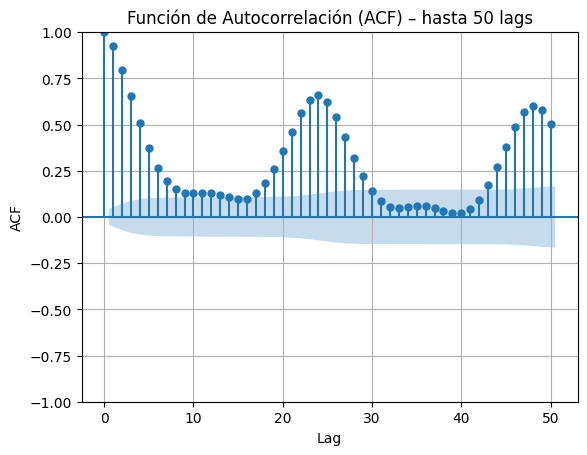

In [14]:
LAGS_ACF = 50  # ajusta según tu serie
plt.figure(figsize=(10,5))
plot_acf(df_interp['o3'], lags=LAGS_ACF, alpha=0.05)
plt.title(f"Función de Autocorrelación (ACF) – hasta {LAGS_ACF} lags")
plt.xlabel("Lag"); plt.ylabel("ACF"); plt.grid(True); plt.show()

Tomamos q=9, y vemos la estacionalidad con esas formas sinusoidales.

In [15]:
y = df_interp['o3'].astype(float)

In [16]:
y.isna().sum()

0

In [17]:
freq = pd.infer_freq(y.index)
y = y.asfreq(freq)

In [18]:
n = len(y)
train_end = int(0.85*n)
valid_end = int(0.95*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

y_bt = pd.concat([y_train, y_valid])

In [26]:
!pip uninstall numpy -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [27]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
river 0.22.0 requires scipy<2.0.0,>=1.14.1, but you have scipy 1.13.1 which is incompatible.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error
from math import sqrt

# --- Función RMSE ---
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# --- Función de backtesting ---
def backtest_arima(y_bt, y_valid, order=(1,1,1), horizon=24, step=8, verbose=True):
    """
    y_bt: Serie completa hasta el final de validación (train + valid)
    y_valid: Serie de validación
    order: Parámetros del modelo ARIMA(p,d,q)
    horizon: número de pasos a predecir en cada iteración
    step: cuántos pasos avanza la ventana cada vez
    """

    n_valid = len(y_valid)
    split_point = len(y_bt) - n_valid  # punto donde empieza la validación

    preds = []
    reals = []

    for i in range(0, n_valid - horizon + 1, step):
        train_end = split_point + i
        test_end = train_end + horizon

        y_train_window = y_bt.iloc[:train_end]
        y_test_window = y_bt.iloc[train_end:test_end]

        # --- Entrenamiento ---
        model = ARIMA(y_train_window, order=order)
        res = model.fit()

        # --- Predicción ---
        pred = res.forecast(steps=horizon)
        preds.extend(pred)
        reals.extend(y_test_window.values)

        if verbose:
            print(f"Iteración {i//step+1}: predijo desde {y_test_window.index[0]} hasta {y_test_window.index[-1]}")

    # --- Ajuste final de longitudes ---
    preds = preds[:n_valid]
    reals = reals[:n_valid]

    preds = pd.Series(preds, index=y_valid.index[:len(preds)])
    reals = pd.Series(reals, index=y_valid.index[:len(reals)])

    # --- Métricas ---
    MAE = mae(reals, preds)
    RMSE = rmse(reals, preds)

    if verbose:
        print(f"\n[ARIMA{order}] MAE={MAE:.3f}  RMSE={RMSE:.3f}")

    # --- Visualización ---
    plt.figure(figsize=(10,4))
    y_valid.plot(label="Real (validación)", alpha=0.6)
    preds.plot(label="Predicho (backtest)", color="tomato")
    plt.title(f"Backtesting ARIMA{order} (solo validación)")
    plt.xlabel("Fecha"); plt.ylabel("Nivel")
    plt.legend()
    plt.show()

    return preds, reals, MAE, RMSE

In [40]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignora SOLAMENTE este tipo específico de advertencia
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')

##### IMPORTAMTE -> MAYOR p y q -> MAYOR TIEMPO DE CÓMPUTO

Iteración 1: predijo desde 2023-12-19 09:00:00 hasta 2023-12-20 08:00:00
Iteración 2: predijo desde 2023-12-19 17:00:00 hasta 2023-12-20 16:00:00
Iteración 3: predijo desde 2023-12-20 01:00:00 hasta 2023-12-21 00:00:00
Iteración 4: predijo desde 2023-12-20 09:00:00 hasta 2023-12-21 08:00:00
Iteración 5: predijo desde 2023-12-20 17:00:00 hasta 2023-12-21 16:00:00
Iteración 6: predijo desde 2023-12-21 01:00:00 hasta 2023-12-22 00:00:00
Iteración 7: predijo desde 2023-12-21 09:00:00 hasta 2023-12-22 08:00:00
Iteración 8: predijo desde 2023-12-21 17:00:00 hasta 2023-12-22 16:00:00
Iteración 9: predijo desde 2023-12-22 01:00:00 hasta 2023-12-23 00:00:00
Iteración 10: predijo desde 2023-12-22 09:00:00 hasta 2023-12-23 08:00:00
Iteración 11: predijo desde 2023-12-22 17:00:00 hasta 2023-12-23 16:00:00
Iteración 12: predijo desde 2023-12-23 01:00:00 hasta 2023-12-24 00:00:00
Iteración 13: predijo desde 2023-12-23 09:00:00 hasta 2023-12-24 08:00:00
Iteración 14: predijo desde 2023-12-23 17:00:00

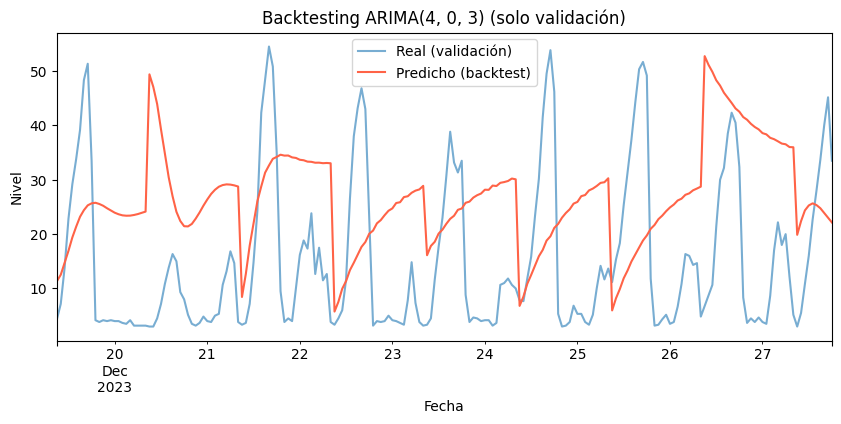

In [44]:
# Definir tu horizonte (ej. predicciones de un día)
HORIZON = 24  # si la serie es horaria

preds, reals, MAE, RMSE = backtest_arima(y_bt, y_valid, order=(4,0,3), horizon=24)


[TEST] MAE=15.449  RMSE=16.592


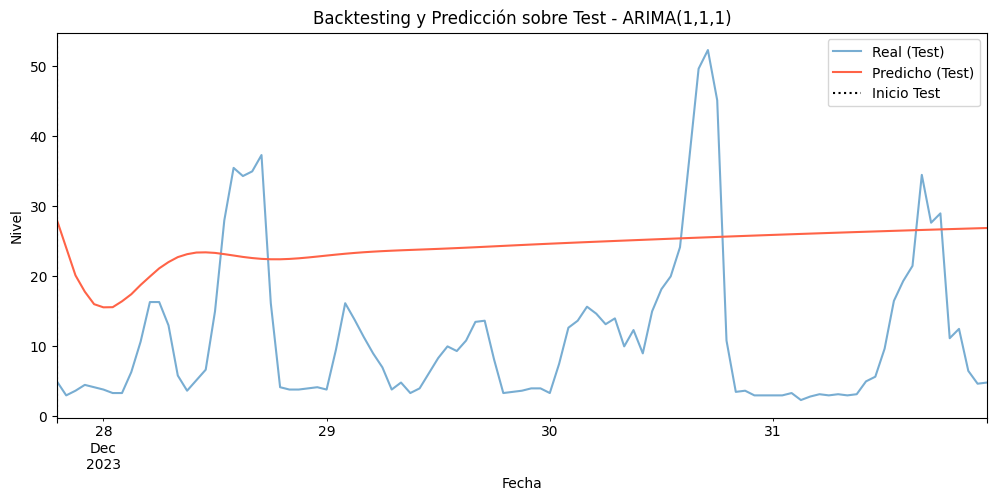

In [46]:
model_final = ARIMA(y_bt, order=(4,0,3))
res_final = model_final.fit()

# --- Predicción sobre el test ---
preds_test = res_final.forecast(steps=len(y_test))
preds_test = pd.Series(preds_test, index=y_test.index)

# --- Métricas sobre el test ---
MAE_test = mae(y_test, preds_test)
RMSE_test = rmse(y_test, preds_test)

print(f"\n[TEST] MAE={MAE_test:.3f}  RMSE={RMSE_test:.3f}")

# --- Visualización completa ---
plt.figure(figsize=(12,5))
y_test.plot(label="Real (Test)", alpha=0.6)
preds_test.plot(label="Predicho (Test)", color="tomato")
plt.axvline(y_test.index[0], color="black", linestyle=":", label="Inicio Test")
plt.title("Backtesting y Predicción sobre Test - ARIMA(1,1,1)")
plt.xlabel("Fecha"); plt.ylabel("Nivel")
plt.legend()
plt.show()

## SARIMAX (p,d,q, s, P, D, Q):

p → orden autorregresivo (AR)

d -> diferenciación

q → orden de media móvil (MA)

s -> Periodo de estacionalidad -> 24    

P → orden estacional autorregresivo (SAR) -> Cuántos valores pasados separados por un ciclo estacional se usan (por ejemplo,

D -> orden estacional de diferenciación -> Cuántas veces se diferencia la serie a nivel estacional

Q → orden estacional de media móvil (SMA) ->  Cuántos errores pasados separados por un ciclo estacional se usan.

Para tratar la estacionalidad usaremos SARIMAX con SKforecast para el modelo y el backtesting, y pmdarima para conseguir los mejores parámetros.

In [25]:
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold, backtesting_sarimax, grid_search_sarimax
from skforecast.plot import set_dark_theme
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
!pip uninstall numpy -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


You can safely remove it manually.
You can safely remove it manually.


In [28]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
river 0.22.0 requires scipy<2.0.0,>=1.14.1, but you have scipy 1.13.1 which is incompatible.


In [29]:
!pip install pmdarima==2.0.4
import pmdarima
from pmdarima.arima import auto_arima

  Using cached pmdarima-2.0.4-cp312-cp312-win_amd64.whl.metadata (8.0 kB)
Using cached pmdarima-2.0.4-cp312-cp312-win_amd64.whl (625 kB)


In [30]:
import numpy, pmdarima, statsmodels
print("numpy:", numpy.__version__)
print("pmdarima:", pmdarima.__version__)
print("statsmodels:", statsmodels.__version__)

numpy: 1.26.4
pmdarima: 2.0.4
statsmodels: 0.14.1


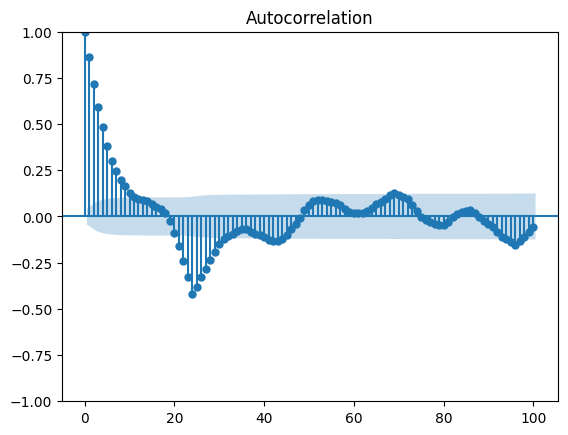

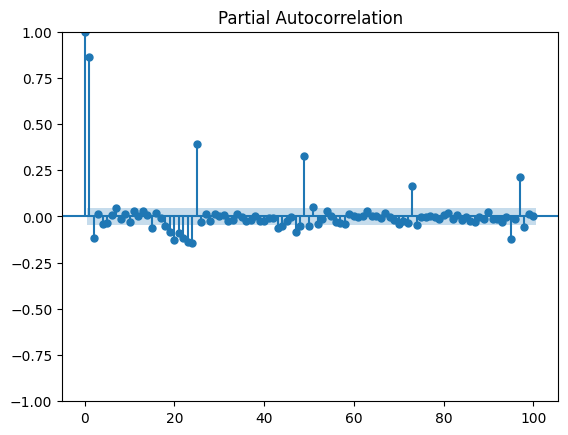

In [33]:
y_seasonal_diff = y.diff(24).dropna()
plot_acf(y_seasonal_diff, lags=100)
plot_pacf(y_seasonal_diff, lags=100)
plt.show()

Picos claros en el lag 24 -> P=1, Q=1

In [35]:
from pmdarima.arima import auto_arima
warnings.filterwarnings("ignore", category=FutureWarning)
auto_model = auto_arima(
    y,
    seasonal=True,
    m=24,         # periodo estacional (s)
    trace=True,
    suppress_warnings=True,
    error_action="ignore",
    start_p=3, max_p=7, # rango de búsqueda para p
    start_q=6, max_q=10, # rango de búsqueda para q
    max_P=1, max_Q=1,  # límites de búsqueda
    d=None, D=None,                       # auto-detección de diferenciación
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(3,1,6)(1,0,1)[24] intercept   : AIC=inf, Time=13.70 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=14445.212, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=14026.365, Time=1.08 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=14081.857, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=14443.218, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=14191.139, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=14074.882, Time=1.29 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=14100.118, Time=0.76 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=14027.389, Time=1.53 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=14027.426, Time=1.63 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=14026.437, Time=0.92 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=14029.427, Time=1.70 sec
 ARIMA(1,1,0)(1,0,0)[24]             : AIC=14024.368, Time=0.40 sec
 ARIMA(1,1,0)(0,

In [37]:
!pip uninstall pmdarima -y
!pip install -U numpy

In [43]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1,1, 1, 24), maxiter=200),
             )
    

In [ ]:
n = len(y)
train_end = int(0.85*n)
valid_end = int(0.95*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

#Backtesting con reajuste y tamaño del conjunto de entrenamiento fijo
cv = TimeSeriesFold(
    steps=24,                          # Horizonte de predicción (por ejemplo, un día si tus datos son horarios)
    initial_train_size=int(len(y)*0.85),# Tamaño del primer bloque de entrenamiento (~80%)
    fixed_train_size=True,            #  Ventana deslizante (rolling window)
    refit = 3   # reentrena cada 3 folds
)

In [90]:
y_bt = pd.concat([y_train, y_valid]) #haremos backtesting solo con esto

Information of folds
--------------------
Number of observations used for initial training: 1714
Number of observations used for backtesting: 202
    Number of folds: 9
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 10 observations.

Fold: 0
    Training:   2023-10-08 23:00:00 -- 2023-12-19 08:00:00  (n=1714)
    Validation: 2023-12-19 09:00:00 -- 2023-12-20 08:00:00  (n=24)
Fold: 1
    Training:   2023-10-09 23:00:00 -- 2023-12-20 08:00:00  (n=1714)
    Validation: 2023-12-20 09:00:00 -- 2023-12-21 08:00:00  (n=24)
Fold: 2
    Training:   2023-10-10 23:00:00 -- 2023-12-21 08:00:00  (n=1714)
    Validation: 2023-12-21 09:00:00 -- 2023-12-22 08:00:00  (n=24)
Fold: 3
    Training:   2023-10-11 23:00:00 -- 2023-12-22 08:00:00  (n=1714)
    Validation: 2023-12-22 09:00:00 -- 2023-12-23 08:00:00  (n=24)
Fold: 4
    Training:   2023-10-12 23:00:00 -- 202

  0%|          | 0/9 [00:00<?, ?it/s]


[SARIMAX(1,1,1)(1,1,1,24)] MAE=11.055   RMSE=13.563


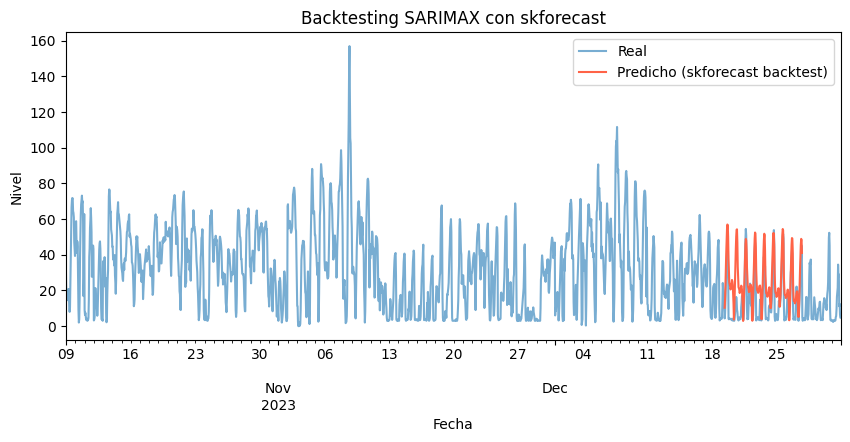

In [91]:
# --- 4. Ejecutar el Backtesting de skforecast ---
# Esto reemplaza TODA tu función 'backtest_arima'

metric, predicciones = backtesting_sarimax(forecaster=forecaster, y=y_bt, exog=None,  cv= cv,
                          metric= 'mean_absolute_error',n_jobs= 'auto', suppress_warnings_fit = True,
                          verbose = True,show_progress= True
                      )

# --- 5. Calcular Métricas Adicionales ---
# 'predicciones' es un DataFrame con las predicciones.
# Unimos con los valores reales para calcular todo.
reales = y[predicciones.index] # Filtramos 'y' para que coincida con las fechas de predicción
MAE = mean_absolute_error(reales, predicciones['pred'])
RMSE = sqrt(mean_squared_error(reales, predicciones['pred']))

print(f"\n[SARIMAX(1,1,1)(1,1,1,24)] MAE={MAE:.3f}   RMSE={RMSE:.3f}")

# --- 6. Visualización ---
plt.figure(figsize=(10,4))
y.plot(label="Real", alpha=0.6)
predicciones['pred'].plot(label="Predicho (skforecast backtest)", color="tomato")
plt.title("Backtesting SARIMAX con skforecast")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()

In [93]:
# Grid search
from skforecast.model_selection import grid_search_sarimax
from skforecast.sarimax import Sarimax
forecaster = ForecasterSarimax(
    regressor=Sarimax()  
)

param_grid = {
    'order': [(1,1,0), (1,1,1), (1,0,1), (1,0,0),(5,0,1), (5,0,9)],
    'seasonal_order': [(1,0,0,24), (1,1,0,24), (1,1,1,24)]
}

results_grid = grid_search_sarimax(
    forecaster=forecaster,
    y=y_bt,
    param_grid=param_grid,
    cv=cv,                      
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=True
)

Number of models compared: 18.


params grid:   0%|          | 0/18 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 1714
Number of observations used for backtesting: 202
    Number of folds: 9
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 10 observations.

Fold: 0
    Training:   2023-10-08 23:00:00 -- 2023-12-19 08:00:00  (n=1714)
    Validation: 2023-12-19 09:00:00 -- 2023-12-20 08:00:00  (n=24)
Fold: 1
    Training:   2023-10-09 23:00:00 -- 2023-12-20 08:00:00  (n=1714)
    Validation: 2023-12-20 09:00:00 -- 2023-12-21 08:00:00  (n=24)
Fold: 2
    Training:   2023-10-10 23:00:00 -- 2023-12-21 08:00:00  (n=1714)
    Validation: 2023-12-21 09:00:00 -- 2023-12-22 08:00:00  (n=24)
Fold: 3
    Training:   2023-10-11 23:00:00 -- 2023-12-22 08:00:00  (n=1714)
    Validation: 2023-12-22 09:00:00 -- 2023-12-23 08:00:00  (n=24)
Fold: 4
    Training:   2023-10-12 23:00:00 -- 202

In [94]:
results_grid.sort_values(by='mean_absolute_error').iloc[0]['params']

{'order': (1, 0, 0), 'seasonal_order': (1, 1, 0, 24)}

Information of folds
--------------------
Number of observations used for initial training: 1714
Number of observations used for backtesting: 202
    Number of folds: 9
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 10 observations.

Fold: 0
    Training:   2023-10-08 23:00:00 -- 2023-12-19 08:00:00  (n=1714)
    Validation: 2023-12-19 09:00:00 -- 2023-12-20 08:00:00  (n=24)
Fold: 1
    Training:   2023-10-09 23:00:00 -- 2023-12-20 08:00:00  (n=1714)
    Validation: 2023-12-20 09:00:00 -- 2023-12-21 08:00:00  (n=24)
Fold: 2
    Training:   2023-10-10 23:00:00 -- 2023-12-21 08:00:00  (n=1714)
    Validation: 2023-12-21 09:00:00 -- 2023-12-22 08:00:00  (n=24)
Fold: 3
    Training:   2023-10-11 23:00:00 -- 2023-12-22 08:00:00  (n=1714)
    Validation: 2023-12-22 09:00:00 -- 2023-12-23 08:00:00  (n=24)
Fold: 4
    Training:   2023-10-12 23:00:00 -- 202

  0%|          | 0/9 [00:00<?, ?it/s]


[SARIMAX(1,0,0)(1,1,0,24)] MAE=5.552   RMSE=8.383


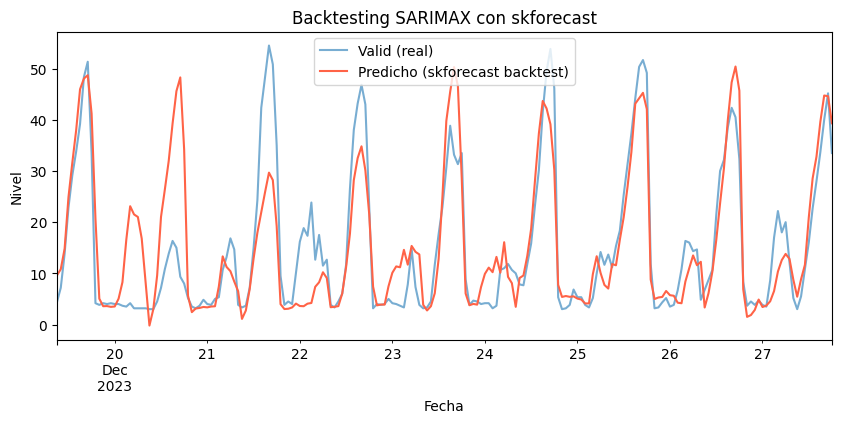

In [102]:
best_forecaster = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 0, 0),
        seasonal_order=(1, 1, 0, 24),
        maxiter=200
    )
)
metric, predicciones = backtesting_sarimax(forecaster=best_forecaster, y=y_bt, exog=None,  cv= cv,
                          metric= 'mean_absolute_error',n_jobs= 'auto', suppress_warnings_fit = True,
                          verbose = True,show_progress= True
                      )

# --- 5. Calcular Métricas Adicionales ---
# 'predicciones' es un DataFrame con las predicciones.
# Unimos con los valores reales para calcular todo.
reales = y[predicciones.index] # Filtramos 'y' para que coincida con las fechas de predicción
MAE = mean_absolute_error(reales, predicciones['pred'])
RMSE = sqrt(mean_squared_error(reales, predicciones['pred']))

print(f"\n[SARIMAX(1,0,0)(1,1,0,24)] MAE={MAE:.3f}   RMSE={RMSE:.3f}")

# --- 6. Visualización ---
plt.figure(figsize=(10,4))
y_valid.plot(label="Valid (real)", alpha=0.6)
predicciones['pred'].plot(label="Predicho (skforecast backtest)", color="tomato")
plt.title("Backtesting SARIMAX con skforecast")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()

PREDICCION SOBRE TEST:


[SARIMAX(1,0,0)(1,1,0,24)] MAE=5.901   RMSE=8.390


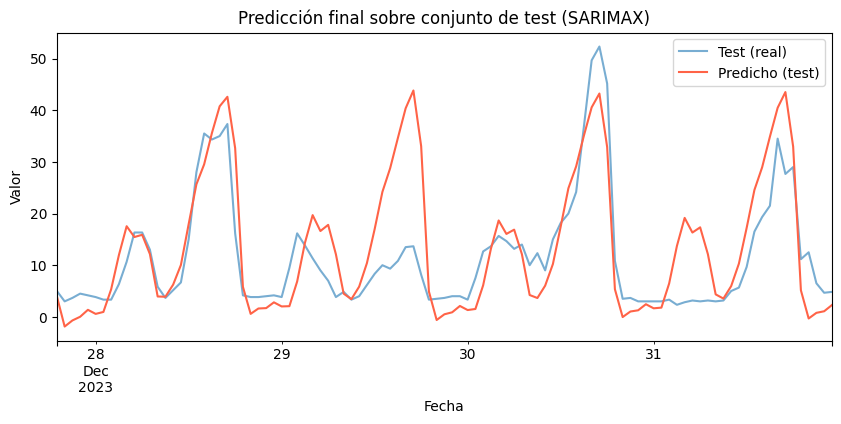

In [103]:
best_forecaster.fit(y=y_bt)

# === Predecir sobre el conjunto de test ===
pred_test = forecaster.predict(steps=len(y_test))

# === Calcular métricas sobre el test ===
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

MAE_test = mean_absolute_error(y_test, pred_test)
RMSE_test = sqrt(mean_squared_error(y_test, pred_test))

print(f"\n[SARIMAX(1,0,0)(1,1,0,24)] MAE={MAE_test:.3f}   RMSE={RMSE_test:.3f}")

plt.figure(figsize=(10,4))
y_test.plot(label="Test (real)", alpha=0.6)
pred_test.plot(label="Predicho (test)", color="tomato")
plt.title("Predicción final sobre conjunto de test (SARIMAX)")
plt.xlabel("Fecha"); plt.ylabel("Valor"); plt.legend()
plt.show()